In [87]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import string
from nltk.corpus import stopwords
PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.data import load
import re

import tensorflow as tf
from transformer import positional_encoding, EncoderLayer
import matplotlib.pyplot as plt
# from tensorflow.keras.callbacks import EarlyStopping
# from transformers import BertTokenizer , TFBertModel
AUTO = tf.data.experimental.AUTOTUNE

## Data/Preprocessing

In [2]:
data_dir = "kaggle/input/"
bert_dir = "kaggle/input/huggingface-bert-variants/bert-base-uncased/"
train_df = pd.read_csv(data_dir + 'feedback-prize-english-language-learning/train.csv')
test_df = pd.read_csv(data_dir + 'feedback-prize-english-language-learning/test.csv')
sample_df = pd.read_csv(data_dir + 'feedback-prize-english-language-learning/sample_submission.csv')
bert_path = bert_dir + 'bert-base-uncased'
print(train_df.shape, test_df.shape, sample_df.shape)

(3911, 8) (3, 2) (3, 7)


In [3]:
size = train_df.shape[0]
train, validate = int(0.8*size), int(0.2*size)
valid_df = train_df.tail(validate).copy()
train_df = train_df.head(train).copy()
print(train_df.shape, valid_df.shape)

(3128, 8) (782, 8)


In [4]:
# Merging Train and Test Data
train_size = train_df.shape[0]
test_size = test_df.shape[0]
print(train_df.shape, test_df.shape, valid_df.shape)

(3128, 8) (3, 2) (782, 8)


In [5]:
lemmatizer = WordNetLemmatizer()

def preprocess(text) :
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+','', text)
    text = re.sub(r'@[0-9a-zA-Z]*\W+',' ' , text)

    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\#', ' ', text)
    text = re.sub(r'\'', ' ', text)

    list_text = text.split()
    text = ' '.join(list_text)
    return text

In [6]:
text_vocab = set()
pos_vocab = list(load('help/tagsets/upenn_tagset.pickle').keys())
max_text_len = 0
truncate_to = 512
for dataset in [train_df, valid_df, test_df]:
    dataset.drop(['text_id'], axis=1, inplace=True)
    dataset['full_text'] = dataset['full_text'].apply(lambda text : preprocess(text))
    dataset['pos_tag'] = dataset['full_text'].apply(lambda text: pos_tag(word_tokenize(text)))
    # there are 36 possible pos_tags
    dataset['pos'] = dataset['pos_tag'].apply(lambda text: ' '.join([elem[1] for elem in text[:truncate_to]]))
    dataset['tokens'] = dataset['pos_tag'].apply(lambda text: [elem[0] for elem in text[:truncate_to]])
    for tokens in dataset['tokens']:
        text_vocab.update(tokens)
        max_text_len = max(max_text_len, len(tokens))
    dataset['tokens'] = dataset['tokens'].apply(lambda text: ' '.join(text))
    dataset.drop(['full_text'], axis=1, inplace=True)
    dataset.drop(['pos_tag'], axis=1, inplace=True)
all_data = pd.concat((train_df, valid_df, test_df)).reset_index(drop=True)

In [7]:
max_text_len

512

In [8]:
# tag parts of speech, add as feature
train_df.head()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,pos,tokens
0,3.5,3.5,3.0,3.0,4.0,3.0,"NN VBP IN NNS MD VB IN VBG IN NN , IN PRP VBP ...",i think that students would benefit from learn...
1,2.5,2.5,3.0,2.0,2.0,2.5,WRB DT NN VBZ DT NN PRP VBP TO VB PRP VB DT JJ...,when a problem is a change you have to let it ...
2,3.0,3.5,3.0,3.0,3.0,2.5,"NN , JJ IN JJ VBP DT NN NN IN VBG DT NN NN NN ...","dear , principal if u change the school policy..."
3,4.5,4.5,4.5,4.5,4.0,5.0,DT JJS NN IN NN VBZ WRB PRP VBP PRP . VB VBP I...,the best time in life is when you become yours...
4,2.5,3.0,3.0,3.0,2.5,2.5,JJ NN IN NN MD VB IN JJ NNS MD VB NNS TO VB JJ...,small act of kindness can impact in other peop...


## Grammar Model

In [29]:
# "(E)lement-(Wi)se (Dense)" Layer for combining two embeddings (or other multi-feature time sequence data) with a Dense layer applied element-wise (so not exactly Dense, as in the output embedding the first position is only determined by a linear combination of the two embedding values in corresponding positions in the two input embeddings)
# (We picked this name because it was funny)
class EWiDense(tf.keras.layers.Layer):
    def __init__(self, activation=None, **kwargs):
        super(EWiDense, self).__init__(**kwargs)
        self.activation = activation

    def build(self, input_shape):
        self.embedding_size = input_shape[0][-1]
        # print(self.tile_shape)
        self.w1 = self.add_weight(
            shape=[self.embedding_size],
            initializer="ones",
            trainable=True,
            name='w1'
        )
        # print(tf.shape(self.w1))
        self.w2 = self.add_weight(
            shape=[self.embedding_size],
            initializer="ones",
            trainable=True,
            name='w2'
        )
        self.b1 = self.add_weight(
            shape=[self.embedding_size],
            initializer="zeros",
            trainable=True,
            name='b1'
        )

    def call(self, data):  # expected x of two embeddings of shape batch_size, seq_len, embedding_size
        if self.activation:
            return self.activation(tf.multiply(data[0], self.w1) + tf.multiply(data[1], self.w2) + self.b1)
        return tf.multiply(data[0], self.w1) + tf.multiply(data[1], self.w2) + self.b1

In [30]:
# compare standard positional encoding with grammar + positional encodinng
# use encoder networks, but not the decoders because we don't have an output sequence really

class GrammarModel(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
               max_text_len, text_vocab, pos_vocab, dropout_rate=0.1):
        super().__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        with tf.device("/cpu:0"):
            self.text_vectorization = tf.keras.layers.TextVectorization(output_mode='int', output_sequence_length=max_text_len)
            self.text_vectorization.adapt(text_vocab)
            self.pos_vectorization = tf.keras.layers.TextVectorization(output_mode='int', output_sequence_length=max_text_len)
            self.pos_vectorization.adapt(pos_vocab)
            self.word_embedding = tf.keras.layers.Embedding(self.text_vectorization.vocabulary_size(), d_model) # replace
            self.pos_embedding = tf.keras.layers.Embedding(self.pos_vectorization.vocabulary_size(), d_model)
        self.EWiDenseLayer = EWiDense(activation=tf.keras.layers.LeakyReLU())
        self.pos_encoding = tf.Variable(positional_encoding(length=max_text_len, depth=d_model), trainable=False)
        self.pos_scalar = tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.pooling = tf.keras.layers.GlobalAveragePooling1D()
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.dense = tf.keras.layers.Dense(1)

    def call(self, inputs):
        words = inputs[:, 0]
        pos = inputs[:, 1]
        # combine embeddings
        words = self.text_vectorization(words)
        pos = self.pos_vectorization(pos)
        x = self.EWiDenseLayer((self.word_embedding(words), self.pos_embedding(pos)))
        # add positional encoding
        x = x * self.pos_scalar
        x = x + self.pos_encoding
        # dropout
        x = self.dropout(x)
        # add encoding layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
        x = self.dropout(x)
        x = self.pooling(x)
        x = self.layernorm(x)
        return self.dense(x)

In [31]:
## Column-wise RMSE
def MCRMSE(y_true, y_pred):
    mcrmse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(mcrmse), axis=-1, keepdims=True)

In [67]:
def create_model():
    num_layers = 2
    d_model = 64
    dff = 256
    num_heads = 4
    dropout_rate = 0.3
    model = GrammarModel(num_layers, d_model, num_heads, dff, max_text_len, np.array(list(text_vocab)), np.array(list(pos_vocab)), dropout_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5, clipnorm=1, amsgrad=True), loss=MCRMSE, metrics=MCRMSE, run_eagerly=True)
    return model

In [68]:
model = create_model()
# model.summary()

In [69]:
len(train_df.iloc[0][['tokens', 'pos']][0].split())

283

In [70]:
model.text_vectorization.vocabulary_size()

20133

In [71]:
max_text_len

512

In [72]:
model(tf.expand_dims(tf.convert_to_tensor(train_df.iloc[0][['tokens', 'pos']]), 0))
model.summary()

Model: "grammar_model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_14 (Text  multiple                 0         
 Vectorization)                                                  
                                                                 
 text_vectorization_15 (Text  multiple                 0         
 Vectorization)                                                  
                                                                 
 embedding_14 (Embedding)    multiple                  1288512   
                                                                 
 embedding_15 (Embedding)    multiple                  2304      
                                                                 
 e_wi_dense_7 (EWiDense)     multiple                  192       
                                                                 
 encoder_layer_27 (EncoderLa  multiple             

In [73]:
# tf.debugging.disable_traceback_filtering()

In [74]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [75]:
checkpoint_filepath = 'checkpoints_final/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    verbose=1,
    save_weights_only=True,
    mode='min',
    save_best_only=True)
history = model.fit(
                    train_df[['tokens', 'pos']],
                    train_df['grammar'],
                    validation_data = (valid_df[['tokens', 'pos']], valid_df['grammar']),
                    steps_per_epoch= train_df.shape[0]//4,
                    batch_size = 4,
                    epochs= 50,
                    verbose = 1,
                    shuffle= True,
                    callbacks=[model_checkpoint_callback])

Epoch 1/50
782/782 [==============================] - ETA: 0s - loss: 0.8012 - MCRMSE: 0.8012
Epoch 1: val_loss improved from inf to 0.65310, saving model to checkpoints_final\
782/782 [==============================] - 107s 137ms/step - loss: 0.8012 - MCRMSE: 0.8012 - val_loss: 0.6531 - val_MCRMSE: 0.6532
Epoch 2/50
782/782 [==============================] - ETA: 0s - loss: 0.5630 - MCRMSE: 0.5630
Epoch 2: val_loss improved from 0.65310 to 0.62839, saving model to checkpoints_final\
782/782 [==============================] - 91s 117ms/step - loss: 0.5630 - MCRMSE: 0.5630 - val_loss: 0.6284 - val_MCRMSE: 0.6285
Epoch 3/50
782/782 [==============================] - ETA: 0s - loss: 0.5566 - MCRMSE: 0.5566
Epoch 3: val_loss did not improve from 0.62839
782/782 [==============================] - 107s 136ms/step - loss: 0.5566 - MCRMSE: 0.5566 - val_loss: 0.6516 - val_MCRMSE: 0.6515
Epoch 4/50
782/782 [==============================] - ETA: 0s - loss: 0.5554 - MCRMSE: 0.5554
Epoch 4: val_lo

In [76]:
history

In [77]:
history.history

{'loss': [0.8012470006942749,
  0.5630247592926025,
  0.5565518736839294,
  0.5553680658340454,
  0.5514611601829529,
  0.5438314080238342,
  0.5340473055839539,
  0.5191813111305237,
  0.5101017355918884,
  0.49734771251678467,
  0.49943339824676514,
  0.49306151270866394,
  0.49020135402679443,
  0.48532959818840027,
  0.4832874536514282,
  0.47894561290740967,
  0.4794844090938568,
  0.47606727480888367,
  0.47378048300743103,
  0.4707631468772888,
  0.47181662917137146,
  0.4690331220626831,
  0.4622923731803894,
  0.46544119715690613,
  0.4608984887599945,
  0.4618304669857025,
  0.4567420780658722,
  0.45572429895401,
  0.4460531175136566,
  0.4502108097076416,
  0.44403666257858276,
  0.44933509826660156,
  0.4400978684425354,
  0.4455040991306305,
  0.43997493386268616,
  0.4380166232585907,
  0.42877188324928284,
  0.4290151000022888,
  0.43651723861694336,
  0.42925897240638733,
  0.4310767948627472,
  0.42694661021232605,
  0.4263978898525238,
  0.41928085684776306,
  0.4185

In [86]:
model(tf.expand_dims(tf.convert_to_tensor(train_df.iloc[5][['tokens', 'pos']]), 0))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.5768995]], dtype=float32)>

In [81]:
train_df.head()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,pos,tokens
0,3.5,3.5,3.0,3.0,4.0,3.0,"NN VBP IN NNS MD VB IN VBG IN NN , IN PRP VBP ...",i think that students would benefit from learn...
1,2.5,2.5,3.0,2.0,2.0,2.5,WRB DT NN VBZ DT NN PRP VBP TO VB PRP VB DT JJ...,when a problem is a change you have to let it ...
2,3.0,3.5,3.0,3.0,3.0,2.5,"NN , JJ IN JJ VBP DT NN NN IN VBG DT NN NN NN ...","dear , principal if u change the school policy..."
3,4.5,4.5,4.5,4.5,4.0,5.0,DT JJS NN IN NN VBZ WRB PRP VBP PRP . VB VBP I...,the best time in life is when you become yours...
4,2.5,3.0,3.0,3.0,2.5,2.5,JJ NN IN NN MD VB IN JJ NNS MD VB NNS TO VB JJ...,small act of kindness can impact in other peop...


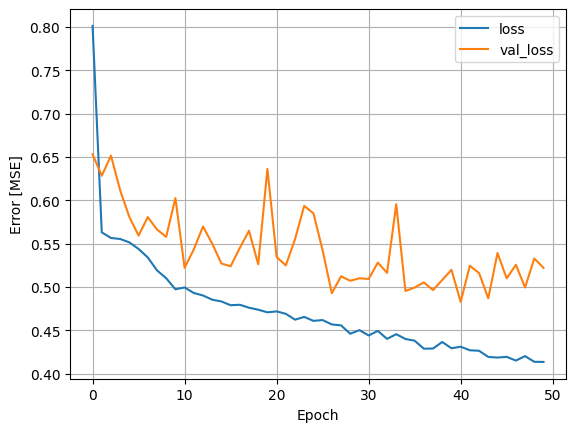

In [88]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [MSE]')
plt.legend()
plt.grid(True)

In [93]:
import json
json.dump(history.history, open("history.json", 'w'))

## Syntax Model

In [1]:
class SyntaxModel(GrammarModel):
    def __init__(self, hidden_size, *args, **kwargs):
        super(SyntaxModel, self).__init__(*args, **kwargs)
        self.inter_dense = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.syntax_dense = tf.keras.layers.Dense(1)

    def call(self, inputs):
        words = inputs[:, 0]
        pos = inputs[:, 1]
        # combine embeddings
        words = self.text_vectorization(words)
        pos = self.pos_vectorization(pos)
        x = self.EWiDenseLayer((self.word_embedding(words), self.pos_embedding(pos)))
        # add positional encoding
        x = x * self.pos_scalar
        x = x + self.pos_encoding
        # dropout
        x = self.dropout(x)
        # add encoding layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
        x = self.pooling(x)
        x = self.layernorm(x)
        encoder_out = x #(batch_size, embed_size)
        grammar_out = self.dense(x) #(batch_size, 1)
        
        concatenated = tf.concat((encoder_out, grammar_out), axis=1)
        x = self.inter_dense(concatenated)
        syntax_out = self.syntax_dense(x)
        return tf.concat((grammar_out, syntax_out), axis=1)

from utils.lr_scheduler import TransformerScheduler

def create_syntax_model():
    num_layers = 6
    d_model = 64
    dff = 256
    num_heads = 8
    dropout_rate = 0.2
    model = SyntaxModel(128, num_layers, d_model, num_heads, dff, max_text_len, np.array(list(text_vocab)), np.array(list(pos_vocab)), dropout_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TransformerScheduler(1, d_model, 4000), beta_1=0.9, beta_2=0.98, clipnorm=1), loss=MCRMSE, metrics=MCRMSE, run_eagerly=True)
    return model

NameError: name 'GrammarModel' is not defined

In [92]:
syntax_model = create_syntax_model()
syntax_model(tf.expand_dims(tf.convert_to_tensor(train_df.iloc[0][['tokens', 'pos']]), 0))
syntax_model.summary()

NameError: name 'test' is not defined

In [ ]:
batch_size = 4
deez_nuts = syntax_model.fit(
    train_df[['tokens', 'pos']],
    train_df[['grammar', 'syntax']],
    validation_data = (valid_df[['tokens', 'pos']], valid_df[['grammar', 'syntax']]),
    steps_per_epoch= train_df.shape[0]//batch_size,
    batch_size = batch_size,
    epochs= 1,
    verbose = 1,
    shuffle= True,
)